In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Data Acquisition 

In [2]:
def file_converter(path):
    head, sep, tail = path.partition('.')
    if tail.lower() in ['xls', 'xlsx', 'xlsm', 'xlsb', 'odf', 'ods' 'odt']:
        read_file = pd.read_excel(path)
    
    new_path = head + '.csv'
    read_file.to_csv(new_path, index = None, header=True)
    return new_path

In [3]:
# load, average and merge sensor samples
data_dir = '../data/raw/Bearing_Nasa'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)
    
merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

print("Dataset shape:", merged_data.shape)
merged_data.head()

Dataset shape: (6, 4)


/tmp/ipykernel_38852/1193243194.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(dataset_mean_abs)
/tmp/ipykernel_38852/1193243194.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(dataset_mean_abs)
/tmp/ipykernel_38852/1193243194.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(dataset_mean_abs)
/tmp/ipykernel_38852/1193243194.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(dataset_mean_abs)
/tmp/ipykernel_38852/1193243194.py:10: FutureWarning: The frame.append method is deprecated and will

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004.02.12.11.12.39,0.061361,0.075609,0.082837,0.045118
2004.02.12.11.22.39,0.061665,0.073279,0.084879,0.044172
2004.02.12.11.42.39,0.061231,0.074172,0.082022,0.043840
2004.02.12.11.02.39,0.061455,0.073844,0.084457,0.045081
2004.02.12.11.32.39,0.061944,0.074593,0.082626,0.044659


In [4]:
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('../data/processed/Bearing_Nasa_data.csv')

## Plotting

In [5]:
bearing_data = pd.read_csv('../data/processed/Bearing_Nasa_data.csv')

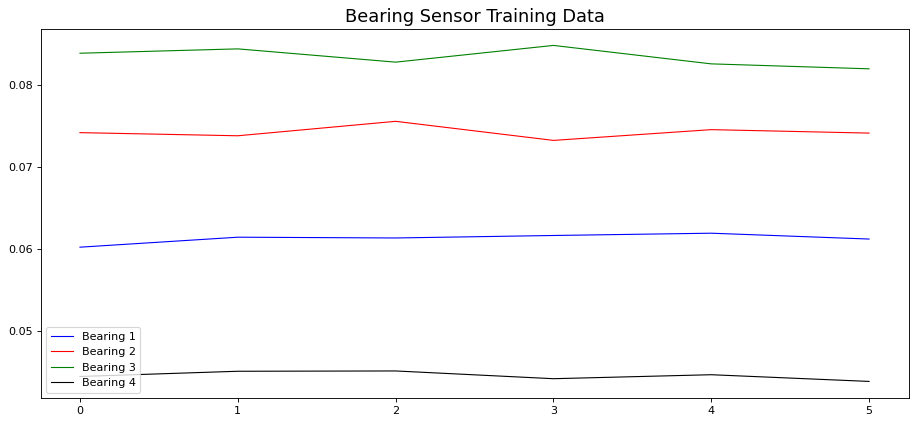

In [6]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(bearing_data['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(bearing_data['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(bearing_data['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(bearing_data['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

## Postgres

In [7]:
import psycopg2
from psycopg2 import sql
import pandas as pd

In [8]:
# Connect to the default postgres database as the admin user
conn = psycopg2.connect(
    host="localhost",
    user="postgres",
    password="postgres"
)

# Set autocommit mode on
conn.autocommit = True

# Create a new database named "my_database"
with conn.cursor() as cur:
    cur.execute("SELECT 1 FROM pg_catalog.pg_database WHERE datname = 'python_db'")
    exists = cur.fetchone()
    if not exists:
      print("Creation of the Database")
      cur.execute('CREATE DATABASE python_db')

# Close the connection
conn.close()

In [9]:
def write_dataframe_to_postgres(df, table_name, db_config):
    # Connect to the database
    conn = psycopg2.connect(**db_config)
    cur = conn.cursor()

    # Define the column names and types
    columns = df.columns.tolist()
    column_types = ['VARCHAR(255)' for col in columns]

    # Create the table
    create_table_query = sql.SQL("CREATE TABLE IF NOT EXISTS {} ({})").format(
        sql.Identifier(table_name),
        sql.SQL(',').join(
            sql.SQL("{} {}").format(sql.Identifier(col), sql.SQL(col_type))
            for col, col_type in zip(columns, column_types)
        )
    )
    cur.execute(create_table_query)

    data = [tuple(row) for row in df.to_numpy()]                # Convert the DataFrame to a list of tuples

    # Define the insert statement
    insert_query = sql.SQL("INSERT INTO {} ({}) VALUES ({})").format(
        sql.Identifier(table_name),
        sql.SQL(',').join(map(sql.Identifier, columns)),
        sql.SQL(',').join(sql.Placeholder() * len(columns))
    )

    cur.executemany(insert_query, data)                         # Insert the data
    conn.commit()                                               # Commit the transaction

    # Close the cursor and connection
    cur.close()
    conn.close()

    print(f"Successfully wrote {len(data)} rows to table {table_name} in database {db_config['database']}!")


In [10]:
def parse_date_column(df):
    date_columns = []
    df_col = df.columns
    for col in df_col:
        try:
            parsed_date = pd.to_datetime(df[col], infer_datetime_format=True)
            if pd.Series(parsed_date).notna().all():
                date_columns.append(col)
                df[col] = parsed_date
        except ValueError:
            pass

    return df, date_columns

In [11]:
def read_table_from_postgres(table_name, db_config):
    conn = psycopg2.connect(**db_config)                    # Connect to the database
    df = pd.read_sql(f"SELECT * FROM \"{table_name}\"", conn)   # Read the table into a DataFrame
    conn.close()                                            # Close the connection
    df, date_column = parse_date_column(df)
    df.rename(columns={date_column[0]: "Date_parsed"})
    df = df.dropna(axis=0, subset=['Date_parsed'])
    df = df.set_index('Date_parsed')
    df = df.sort_index()

    return df

In [12]:
test_bearing_data = pd.read_csv('../data/processed/test_Bearing_Nasa.csv')
test_table_name = 'test_Bearing_Nasa'

train_bearing_data = pd.read_csv('../data/processed/train_Bearing_Nasa.csv')
train_table_name = 'train_Bearing_Nasa'
db_config = {
    'host': 'localhost',
    'database': 'python_db',
    'user': 'postgres',
    'password': 'postgres'
}

write_dataframe_to_postgres(test_bearing_data, test_table_name, db_config)
write_dataframe_to_postgres(train_bearing_data, train_table_name, db_config)

Successfully wrote 246 rows to table test_Bearing_Nasa in database python_db!
Successfully wrote 736 rows to table train_Bearing_Nasa in database python_db!


In [23]:
df = read_table_from_postgres(train_table_name, db_config)
df

/tmp/ipykernel_38852/2630714877.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT * FROM \"{table_name}\"", conn)   # Read the table into a DataFrame


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
Date_parsed,,,,
2004-02-12 10:52:39,0.0602364373260413,0.0742266223936715,0.0839260706089164,0.0444430880414082
2004-02-12 10:52:39,0.0602364373260413,0.0742266223936715,0.0839260706089164,0.0444430880414082
2004-02-12 11:02:39,0.0614554421602617,0.073844084183798,0.0844574442111431,0.0450814004590067
2004-02-12 11:02:39,0.0614554421602617,0.073844084183798,0.0844574442111431,0.0450814004590067
2004-02-12 11:12:39,0.0613607598027247,0.0756087699594706,0.082836808437912,0.0451183651545485
...,...,...,...,...
2004-02-17 13:02:39,0.1097789931148981,0.0780170418477464,0.0794486547194687,0.0498081449289516
2004-02-17 13:12:39,0.1100961961033253,0.0772929830558132,0.0791584550026856,0.0500879437472533
2004-02-17 13:12:39,0.1100961961033253,0.0772929830558132,0.0791584550026856,0.0500879437472533


In [21]:
def drop_duplicates(table_name, db_config):
    conn = psycopg2.connect(**db_config)    
    try:
        cursor = conn.cursor()
        cursor.execute(f"SELECT DISTINCT * FROM \"{table_name}\";")
        conn.commit()
        print("Duplicate rows removed")
    except Exception as e:
        print("Error:", e)

drop_duplicates(train_table_name, db_config)

Duplicate rows removed
